In [1]:
!pip install duckdb --no-index --find-links=file:///kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/duck_pkg
#!pip install polars --no-index --find-links=file:///kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/polars_pkg

Looking in links: file:///kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/duck_pkg
Processing /kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/duck_pkg/duckdb-0.8.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import polars as pl
import duckdb as dd
#from tqdm import tqdm
import matplotlib.pyplot as plt
#import cv2
#from pydicom import dcmread
import warnings
#from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import pickle
#import gc
import ctypes
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow import keras

In [3]:
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

Number of accelerators:  2


## Train, Test, Validation & holdout splits
### holdout set to be used for CV

In [5]:
condition_for_training = 'left_neural_foraminal_narrowing'
vertebrae_position = 'l1_l2'

metadata_file_path = '/kaggle/input/left-neural-foraminal-narrowing-metadata/{0}_{1}_feature_metadata.csv'\
.format(condition_for_training, vertebrae_position)
metadata_df = pl.read_csv(metadata_file_path, low_memory=True)

In [6]:
metadata_df_severe = metadata_df.filter(pl.col('encoded_severity')==2)
metadata_df_moderate = metadata_df.filter(pl.col('encoded_severity')==0)

In [7]:
print(metadata_df_severe.shape)

(117, 3)


In [11]:
x_train, x_test_val = train_test_split(metadata_df, test_size=0.4, random_state=42)
x_test, x_valid = train_test_split(x_test_val, test_size=0.2, random_state=42)

print("Training data shape : {0}".format(x_train.shape))
print("Test data shape : {0}".format(x_test.shape))
print("Validation data shape : {0}".format(x_valid.shape))

Training data shape : (88249, 3)
Test data shape : (47067, 3)
Validation data shape : (11767, 3)


In [9]:
dd.sql("select severity, encoded_severity, count(distinct(full_img_path)) as images from metadata_df group by severity \
       , encoded_severity").pl()

severity,encoded_severity,images
str,i64,i64
"""Normal/Mild""",1,141667
"""Moderate""",0,5299
"""Severe""",2,117


In [7]:
pl.Config(fmt_str_lengths=1000)
metadata_df.filter(pl.col('encoded_severity')==2).head(10)

full_img_path,severity,encoded_severity
str,str,i64
"""/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/325485990/4123874213/12.dcm""","""Severe""",2
"""/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/325485990/4123874213/9.dcm""","""Severe""",2
"""/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/325485990/4123874213/14.dcm""","""Severe""",2
"""/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/325485990/4123874213/11.dcm""","""Severe""",2
"""/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/325485990/4123874213/10.dcm""","""Severe""",2
"""/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/325485990/4123874213/1.dcm""","""Severe""",2
"""/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/325485990/4123874213/15.dcm""","""Severe""",2
"""/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/325485990/4123874213/2.dcm""","""Severe""",2
"""/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/325485990/4123874213/8.dcm""","""Severe""",2


W: DcmMetaInfo: No Group Length available in Meta Information Header


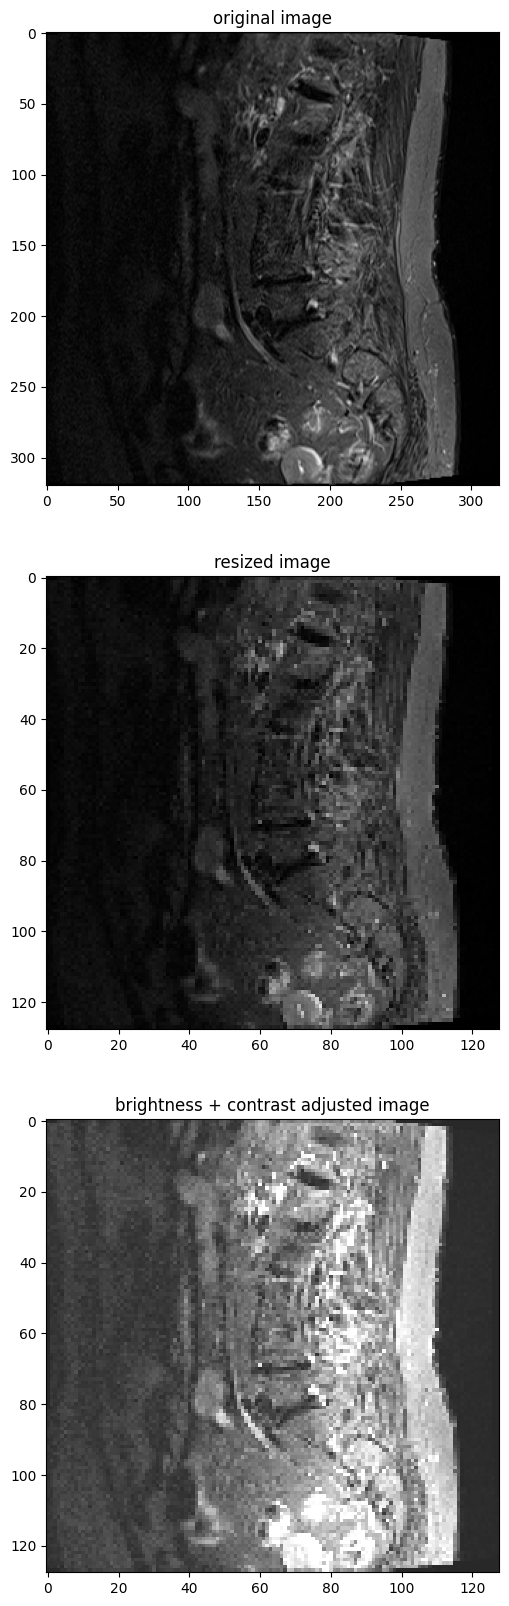

In [13]:
image_bytes \
= tf.io.read_file('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/325485990/4123874213/12.dcm')

image_original = tfio.image.decode_dicom_image(image_bytes, scale='auto', dtype=tf.float32)

m, M=tf.math.reduce_min(image_original), tf.math.reduce_max(image_original)
image = (tf.image.grayscale_to_rgb(image_original)-m)/(M-m)
image_resized = tf.image.resize(image, (128,128))

brt_image = tf.image.adjust_brightness(image, delta=0.3)

contrast_img = tf.image.adjust_contrast(brt_image, contrast_factor=2.0)

contrast_img_resized = tf.image.resize(contrast_img, (128,128))

#sqzd_image = tf.squeeze(image)
#image_resized = tf.reshape(image, [128, 128, 3])

fig, axes = plt.subplots(3,1, figsize=(20,20))
axes[0].imshow(np.squeeze(image_original.numpy()), cmap='gray')
axes[0].set_title('original image')
axes[1].imshow(np.squeeze(image_resized.numpy()), cmap='gray')
axes[1].set_title('resized image')
axes[2].imshow(np.squeeze(contrast_img_resized.numpy()), cmap='gray')
axes[2].set_title('brightness + contrast adjusted image');

In [15]:
tf.squeeze(contrast_img_resized).get_shape()

TensorShape([128, 128, 3])

## Preprocessing functions

In [8]:
def read_and_parse_dicom_files(full_file_path):
    tf.config.run_functions_eagerly(True)
    raw_image = tf.io.read_file(full_file_path)
    sp = tf.strings.split(tf.gather(tf.strings.split(full_file_path, 'images/'), 1), '/')
    N = tf.size(sp)
    LEN = tf.strings.length(tf.gather(sp, 0))+tf.strings.length(tf.gather(sp, 2))
    
    # Add missing file metadata to avoid warnnigs flooding
    if   LEN==12: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x92\x00\x00\x00\x02\x00\x01\x00')
    elif LEN==13: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x92\x00\x00\x00\x02\x00\x01\x00')
    elif LEN==14: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x94\x00\x00\x00\x02\x00\x01\x00')
    elif LEN==15: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x94\x00\x00\x00\x02\x00\x01\x00')
    elif LEN==16: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x96\x00\x00\x00\x02\x00\x01\x00')
    elif LEN==17: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x96\x00\x00\x00\x02\x00\x01\x00')
    elif LEN==18: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x98\x00\x00\x00\x02\x00\x01\x00')
    
    image = tfio.image.decode_dicom_image(raw_image, scale='auto', dtype=tf.float32)
    m, M=tf.math.reduce_min(image), tf.math.reduce_max(image)
    image = (tf.image.grayscale_to_rgb(image)-m)/(M-m)
    image = tf.image.resize(image, (128,128))
    return tf.squeeze(image)

def load_dataset(image_path, labels):
    image = read_and_parse_dicom_files(image_path)
    return {"images": tf.cast(image, tf.float32), "labels": tf.cast(labels, tf.float32)}

def dict_to_tuple(inputs):
    return inputs["images"], inputs["labels"]

In [16]:
def read_parse_n_augment_dicom_files(full_file_path):
    tf.config.run_functions_eagerly(True)
    raw_image = tf.io.read_file(full_file_path)
    sp = tf.strings.split(tf.gather(tf.strings.split(full_file_path, 'images/'), 1), '/')
    N = tf.size(sp)
    LEN = tf.strings.length(tf.gather(sp, 0))+tf.strings.length(tf.gather(sp, 2))
    
    # Add missing file metadata to avoid warnnigs flooding
    if   LEN==12: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x92\x00\x00\x00\x02\x00\x01\x00')
    elif LEN==13: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x92\x00\x00\x00\x02\x00\x01\x00')
    elif LEN==14: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x94\x00\x00\x00\x02\x00\x01\x00')
    elif LEN==15: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x94\x00\x00\x00\x02\x00\x01\x00')
    elif LEN==16: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x96\x00\x00\x00\x02\x00\x01\x00')
    elif LEN==17: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x96\x00\x00\x00\x02\x00\x01\x00')
    elif LEN==18: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x98\x00\x00\x00\x02\x00\x01\x00')
    
    image = tfio.image.decode_dicom_image(raw_image, scale='auto', dtype=tf.float32)
    m, M=tf.math.reduce_min(image), tf.math.reduce_max(image)
    image = (tf.image.grayscale_to_rgb(image)-m)/(M-m)
    
    brt_image = tf.image.adjust_brightness(image, delta=0.3)
    contrast_img = tf.image.adjust_contrast(brt_image, contrast_factor=2.0)
    contrast_img_resized = tf.image.resize(contrast_img, (128,128))

    return tf.squeeze(contrast_img_resized)

def load_aug_dataset(image_path, labels):
    image = read_parse_n_augment_dicom_files(image_path)
    return {"images": tf.cast(image, tf.float32), "labels": tf.cast(labels, tf.float32)}

In [9]:
def generate_tf_datasets(p_train_df, p_test_df, p_valid_df, p_BATCH_SIZE_PER_REPLICA):

    BATCH_SIZE = p_BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
    
    train_image_filenames = pl.Series(p_train_df.select(pl.col('full_img_path'))).to_list()
    train_image_labels = pl.Series(p_train_df.select(pl.col('encoded_severity'))).to_list()

    test_image_filenames = pl.Series(p_test_df.select(pl.col('full_img_path'))).to_list()
    test_image_labels = pl.Series(p_test_df.select(pl.col('encoded_severity'))).to_list()

    valid_image_filenames = pl.Series(p_valid_df.select(pl.col('full_img_path'))).to_list()
    valid_image_labels = pl.Series(p_valid_df.select(pl.col('encoded_severity'))).to_list()
    
    
    train_dataset = tf.data.Dataset.from_tensor_slices((train_image_filenames, train_image_labels))
    test_dataset = tf.data.Dataset.from_tensor_slices((test_image_filenames, test_image_labels))
    valid_dataset = tf.data.Dataset.from_tensor_slices((valid_image_filenames, valid_image_labels))
    
    train_ds = train_dataset.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True)
    train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

    test_ds = test_dataset.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    test_ds = test_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
    test_ds = test_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True)
    test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

    valid_ds = valid_dataset.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    valid_ds = valid_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
    valid_ds = valid_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True)
    valid_ds = valid_ds.prefetch(tf.data.AUTOTUNE)
    
    return train_ds, test_ds, valid_ds

In [12]:
train_ds, test_ds, valid_ds = generate_tf_datasets(p_train_df=x_train, p_test_df=x_test, p_valid_df=x_valid
                                                   , p_BATCH_SIZE_PER_REPLICA = 45)

/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [19]:
BATCH_SIZE = 45 * strategy.num_replicas_in_sync

metadata_df_severe_filenames = pl.Series(metadata_df_severe.select(pl.col('full_img_path'))).to_list()
metadata_df_severe_labels = pl.Series(metadata_df_severe.select(pl.col('encoded_severity'))).to_list()

metadata_df_severe_dataset = tf.data.Dataset.from_tensor_slices((metadata_df_severe_filenames, metadata_df_severe_labels))

metadata_df_severe_ds = metadata_df_severe_dataset.map(load_aug_dataset, num_parallel_calls=tf.data.AUTOTUNE)
metadata_df_severe_ds = metadata_df_severe_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
metadata_df_severe_ds = metadata_df_severe_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True)
metadata_df_severe_ds = metadata_df_severe_ds.prefetch(tf.data.AUTOTUNE)


combined_train_dataset = train_ds.concatenate(metadata_df_severe_ds)

## v1 Architecture

In [20]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers

with strategy.scope():
    
    rsna_input = layers.Input(shape=(128,128,3), name="rsna_input")

    conv_base = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=rsna_input)
    conv_base.trainable = False

    max_pool_layer_0 = layers.MaxPooling2D(name="max_pool_0", pool_size=(2, 2), strides=(1, 1), padding="same")(conv_base.output)
    max_pool_layer_0 = layers.BatchNormalization()(max_pool_layer_0)

    conv2d_1 = layers.Conv2D(filters=100, kernel_size=4, strides=1, padding="same", activation="relu")(max_pool_layer_0)
    max_pool_layer_1 = layers.MaxPooling2D(name="max_pool_1", pool_size=(2, 2), strides=(1, 1), padding="same")(conv2d_1)
    max_pool_layer_1 = layers.BatchNormalization()(max_pool_layer_1)

    flattened_layer = layers.Flatten()(max_pool_layer_1)

    hidden_layer1 = layers.Dense(200, activation="selu", kernel_initializer=keras.initializers.LecunNormal(seed=None))(flattened_layer)
    hidden_layer1 = layers.BatchNormalization()(hidden_layer1)
    hidden_layer2 = layers.Dense(100, activation="selu", kernel_initializer=keras.initializers.LecunNormal(seed=None))(hidden_layer1)
    hidden_layer2 = layers.BatchNormalization()(hidden_layer2)
    hidden_layer3 = layers.Dense(50, activation="selu", kernel_initializer=keras.initializers.LecunNormal(seed=None))(hidden_layer2)
    hidden_layer3 = layers.BatchNormalization()(hidden_layer3)
    rsna_output = layers.Dense(3, activation="softmax")(hidden_layer3)
    model = tf.keras.Model(rsna_input, rsna_output)

    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("keras_effnet_{0}_{1}.keras".format(condition_for_training, vertebrae_position))
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

    model.compile(loss="sparse_categorical_crossentropy", optimizer="adamax", metrics=["accuracy"])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
history = model.fit(combined_train_dataset, class_weight={0:2, 1:1, 2:4}, epochs=7, validation_data=valid_ds, callbacks=[checkpoint_cb, early_stopping_cb])

model.evaluate(test_ds)

model.save("keras_base_{0}_{1}.h5".format(condition_for_training, vertebrae_position))

Epoch 1/7
495/981 ━━━━━━━━━━━━━━━━━━━━ 12:51 2s/step - accuracy: 0.8265 - loss: 0.7729